# 1. Preparing the Data: a. Split your Colon.csv into Train and Test datasets. b. Apply the PCA and KPCA models (RBF, Polynomial, Linear, and combined kernels) trained on the Train dataset to transform the Test dataset. c. Ensure the dimensionality reduction is consistent with what was performed on the training data.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Load the new dataset
data = pd.read_csv('colon.csv')
print(f"Original Data Shape: {data.shape}")

# Splitting the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# storing the labels separately
train_label = train_data.iloc[:, -1]
test_label = test_data.iloc[:, -1]

# removing the last column from the data itself
train_X = train_data.iloc[:, :-1]
test_X = test_data.iloc[:, :-1]

# converting to numpy
train = train_X.to_numpy()
test = test_X.to_numpy()

def rbf_kernel(x, y, gamma=1.0):
    """ Radial Basis Function (RBF) Kernel """
    return np.exp(-gamma * np.linalg.norm(x - y) ** 2)

def poly_kernel(x, y, degree=3):
    """ Polynomial Kernel """
    return np.dot(x, y) ** degree

def linear_kernel(x, y):
    """ Linear Kernel """
    return np.dot(x, y)

def combined_kernel(x, y, gamma=1.0, degree=3, alpha=0.5):
    """ Combined Kernel """
    return alpha * rbf_kernel(x, y, gamma) + (1 - alpha) * poly_kernel(x, y, degree)

def compute_kernel_matrix(data, kernel_type, kernel_param, alpha=0.5):
    n_samples = data.shape[0]
    kernel_matrix = np.zeros((n_samples, n_samples))

    for i in range(n_samples):
        for j in range(n_samples):
            if kernel_type == 'rbf':
                kernel_matrix[i, j] = rbf_kernel(data[i], data[j], kernel_param)
            elif kernel_type == 'poly':
                kernel_matrix[i, j] = poly_kernel(data[i], data[j], kernel_param)
            elif kernel_type == 'linear':
                kernel_matrix[i, j] = linear_kernel(data[i], data[j])
            elif kernel_type == 'combined':
                kernel_matrix[i, j] = combined_kernel(data[i], data[j], gamma=kernel_param, degree=kernel_param, alpha=alpha)

    return kernel_matrix, n_samples

def my_kpca(data, alpha, kernel_type='rbf', kernel_param=1.0):
    kernel_matrix, n_samples = compute_kernel_matrix(data, kernel_type, kernel_param)

    # Ensure the kernel matrix is symmetric
    kernel_matrix = (kernel_matrix + kernel_matrix.T) / 2

    one_n = np.ones((n_samples, n_samples)) / n_samples
    mean2 = one_n.dot(kernel_matrix).dot(one_n)
    centered_kernel_matrix = kernel_matrix - one_n.dot(kernel_matrix) - kernel_matrix.dot(one_n) + mean2

    eigen_values, eigen_vectors = np.linalg.eigh(centered_kernel_matrix)

    # Ensure eigenvalues and eigenvectors are real
    eigen_values = np.real(eigen_values)
    eigen_vectors = np.real(eigen_vectors)

    idx = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:, idx]

    var_ratio = eigen_values / np.sum(eigen_values)
    cumulative_var_ratio = np.cumsum(var_ratio)
    k = np.argmax(cumulative_var_ratio >= alpha) + 1
    reduced_eigen_vectors = eigen_vectors[:, :k]

    projected_data = np.dot(centered_kernel_matrix, reduced_eigen_vectors)

    return projected_data, reduced_eigen_vectors, mean2, k

# PCA with Scikit-Learn library
# n_components = k which is 335
k = 335
n_components = k
#print(f"The components are: {n_components}")
pca = PCA(n_components=n_components)


def kPCA_NewData(Y, X, eigVector, type='gaussian', para=1, alpha=0.5):
    combined_data = np.vstack([Y, X])
    K_combined, _ = compute_kernel_matrix(combined_data, type, para, alpha)
    K = K_combined[:Y.shape[0], Y.shape[0]:]

    Z = np.dot(K, eigVector)

    return Z

# Apply PCA to training data
projected_train_pca = pca.fit_transform(train)
# Apply PCA for the test data
test_reduced_pca = pca.transform(test)

# Apply KPCA to training data with RBF kernel
projected_train_kpca_rbf, reduced_eigen_vectors_rbf, K_centered_train_rbf, k_rbf = my_kpca(train, alpha=0.9, kernel_type='rbf', kernel_param=0.5)
# Apply KPCA for the test data with RBF kernel
test_reduced_rbf = kPCA_NewData(test, train, reduced_eigen_vectors_rbf, type='gaussian', para=0.5)

# Apply KPCA to training data with Polynomial kernel
projected_train_kpca_poly, reduced_eigen_vectors_poly, K_centered_train_poly, k_poly = my_kpca(train, alpha=0.9, kernel_type='poly', kernel_param=3)
# Apply KPCA for the test data with Polynomial kernel
test_reduced_poly = kPCA_NewData(test, train, reduced_eigen_vectors_poly, type='poly', para=3)

# Apply KPCA to training data with Linear kernel
projected_train_kpca_linear, reduced_eigen_vectors_linear, K_centered_train_linear, k_linear = my_kpca(train, alpha=0.9, kernel_type='linear', kernel_param=1)
# Apply KPCA for the test data with Linear kernel
test_reduced_linear = kPCA_NewData(test, train, reduced_eigen_vectors_linear, type='linear', para=1)

# Apply KPCA to training data with Combined kernel
projected_train_kpca_combined, reduced_eigen_vectors_combined, K_centered_train_combined, k_combined = my_kpca(train, alpha=0.9, kernel_type='combined', kernel_param=0.5)

# Apply KPCA for the test data with Combined Kernel
test_reduced_combined = kPCA_NewData(test, train, reduced_eigen_vectors_combined, type='combined', para=0.5)

print(f"Original Training Data Shape: {train.shape}")
print(f"PCA Reduced Training Data Shape: {projected_train_pca.shape}")
print(f"RBF Kernel Reduced Training Data Shape: {projected_train_kpca_rbf.shape}")
print(f"Polynomial Kernel Reduced Training Data Shape: {projected_train_kpca_poly.shape}")
print(f"Linear Kernel Reduced Training Data Shape: {projected_train_kpca_linear.shape}")
print(f"Combined Kernel Reduced Training Data Shape: {projected_train_kpca_combined.shape}")

print(f"Original Test Data Shape: {test.shape}")
print(f"PCA Reduced Test Data Shape: {test_reduced_pca.shape}")
print(f"RBF Kernel Reduced Test Data Shape: {test_reduced_rbf.shape}")
print(f"Polynomial Kernel Reduced Test Data Shape: {test_reduced_poly.shape}")
print(f"Linear Kernel Reduced Test Data Shape: {test_reduced_linear.shape}")
print(f"Combined Kernel Reduced Test Data Shape: {test_reduced_combined.shape}")

Original Data Shape: (467, 1882)
Original Training Data Shape: (373, 1881)
PCA Reduced Training Data Shape: (373, 335)
RBF Kernel Reduced Training Data Shape: (373, 335)
Polynomial Kernel Reduced Training Data Shape: (373, 4)
Linear Kernel Reduced Training Data Shape: (373, 5)
Combined Kernel Reduced Training Data Shape: (373, 4)
Original Test Data Shape: (94, 1881)
PCA Reduced Test Data Shape: (94, 335)
RBF Kernel Reduced Test Data Shape: (94, 335)
Polynomial Kernel Reduced Test Data Shape: (94, 4)
Linear Kernel Reduced Test Data Shape: (94, 5)
Combined Kernel Reduced Test Data Shape: (94, 4)


# 2. Covariance Matrix Analysis: a. Calculate the covariance matrix of the dataset. b. Identify the top 10 features with the highest covariance values.

In [ ]:
# Convert the data into features and remove the last column
features = data.iloc[:, :-1]
features = features.to_numpy()
#print(features)
# Calculate the covariance matrix of the dataset
cov1 = np.cov(features, rowvar=False)
# Extract the diagonal of the covariance matrix
variances = np.diag(cov1)
# Get the index of the top 10 largest
top_10_index = np.argsort(variances)[-10:][::-1]
#print(top_10_index)
print("Top 10 features with the highest Covariance values:")
for index in top_10_index:
    print(f"Feature{index}: {feature_names[index]} - Covariance: {variances[index]}")

Top 10 features with the highest Covariance values:
Feature189: hsa-mir-143 - Covariance: 14325969991.010242
Feature285: hsa-mir-21 - Covariance: 5365493845.84248
Feature248: hsa-mir-192 - Covariance: 3626592304.8863993
Feature25: hsa-mir-10a - Covariance: 2589585286.3920703
Feature200: hsa-mir-148a - Covariance: 1892076415.8675835
Feature595: hsa-mir-375 - Covariance: 1616765649.988965
Feature26: hsa-mir-10b - Covariance: 511631557.04025203
Feature305: hsa-mir-22 - Covariance: 381265942.71318084
Feature273: hsa-mir-203a - Covariance: 335270887.2537617
Feature1880: hsa-mir-99b - Covariance: 311070765.3015522


# 3. Classification Experiment: For this part, you will implement the following classifiers using sklearn and compare their performance:
    KNN
    Bayes
    Naive Bayes
    LDA
    SVM

## Bayes classifier

In [4]:
class Bayes:
    
    def bayes_classifier(X, y, reg_factor=1e-6):
        classes = np.unique(y)
        # class
        k = len(classes)
        # labels
        n = X.shape[1]

        prior_probabilities = np.empty(k)
        class_means = np.empty((k, n))
        cov_matrices = np.empty((k, n, n))
        # go through the class and find prior_probabilities, means, and covariance matrices
        for i, cls in enumerate(classes):
            Xi = X[y == cls]
            ni = Xi.shape[0]
            prior_probabilities[i] = ni / X.shape[0]
            class_means[i] = np.mean(Xi, axis=0)
            centered_data = Xi - class_means[i]
            cov_matrices[i] = np.dot(centered_data.T, centered_data) / ni + reg_factor * np.eye(n)
        return prior_probabilities, class_means, cov_matrices
    # do the prediction on the class
    def predict(X, prior_probabilities, class_means, cov_matrices):
        k = len(prior_probabilities)
        n = X.shape[0]
        log_probs = np.zeros((n, k))

        for i in range(k):
            centered_data = X - class_means[i]
            inv_cov_matrix = np.linalg.inv(cov_matrices[i])
            term1 = -0.5 * np.sum(centered_data @ inv_cov_matrix * centered_data, axis=1)
            term2 = -0.5 * np.linalg.slogdet(cov_matrices[i])[1]
            term3 = np.log(prior_probabilities[i])
            log_probs[:, i] = term1 + term2 + term3
        # return argmax of log posteriors
        return np.argmax(log_probs, axis=1)

## Classification

In [2]:
# Import all classifiers and PCA, and KPCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
# Import numpy just in case other cell was not run
import numpy as np

[Whole data] KNN classifier accuracy: 34.04%
[PCA] KNN classifier accuracy with 50 components: 34.04%


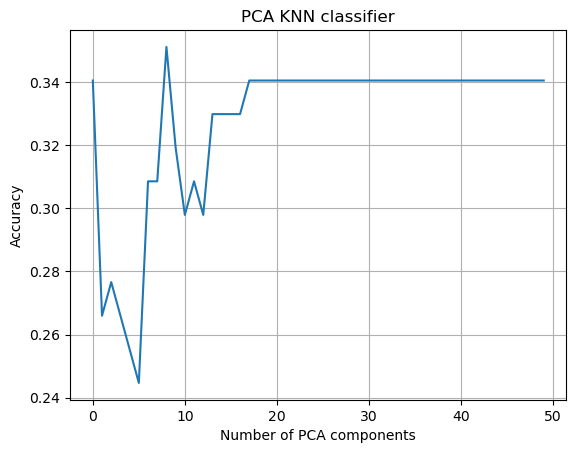

[KPCA rbf] KNN classifier accuracy with 50 components: 32.98%


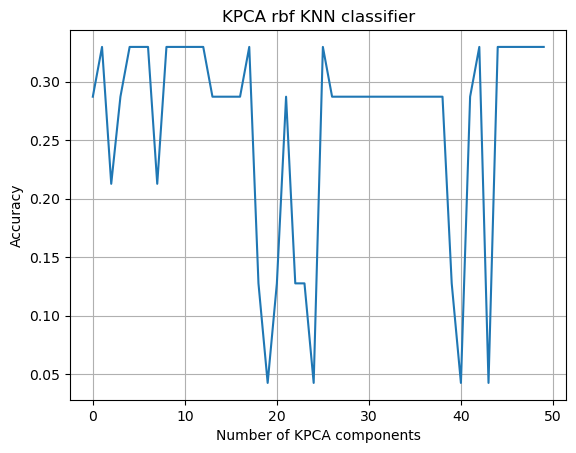

[KPCA poly] KNN classifier accuracy with 50 components: 30.85%


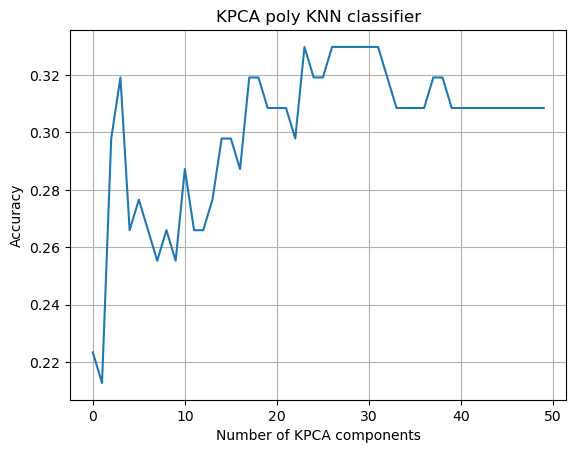

[KPCA linear] KNN classifier accuracy with 50 components: 34.04%


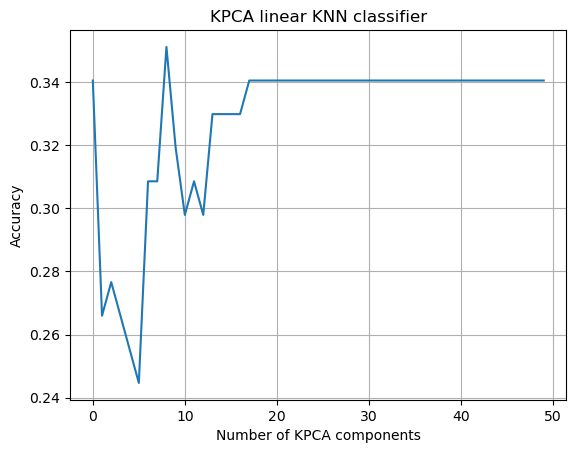

[Top 10 features] KNN classifier accuracy: 31.91%


In [ ]:
#Whole data Classifiers
classifer_data = pd.read_csv('colon.csv')
classifier_data = classifer_data.iloc[:, :-1]
classifier_labels = classifer_data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(classifier_data, classifier_labels, test_size=0.2, random_state=42)
# KNN classifier applied to the whole dataset
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)
KNN_pred = KNN.predict(X_test)
KNN_accuracy = accuracy_score(y_test, KNN_pred) * 100
print('[Whole data] KNN classifier accuracy: %.2f%%' % KNN_accuracy)
# Apply PCA and KPCA to KNN classifier
KNN_results = []
for i in range(1, 51):
    pca = PCA(n_components=i)
    train_reduced = pca.fit_transform(X_train)
    test_reduced = pca.transform(X_test)
    KNN = KNeighborsClassifier()
    KNN.fit(train_reduced, y_train)
    y_KNN_pred = KNN.predict(test_reduced)
    PCA_accuracy = accuracy_score(y_test, y_KNN_pred)
    KNN_results.append(PCA_accuracy)
    if i == 50:
        final_PCA_accuracy = PCA_accuracy

print('[PCA] KNN classifier accuracy with 50 components: %.2f%%' % (final_PCA_accuracy * 100))
plt.plot(KNN_results)
plt.grid()
plt.xlabel('Number of PCA components')
plt.ylabel('Accuracy')
plt.title('PCA KNN classifier')
plt.show()

KNN_kpca_rbf_results = []
for i in range(1, 51):
    kpca = KernelPCA(n_components=i, kernel='rbf', gamma=1.0)
    train_reduced = kpca.fit_transform(X_train)
    test_reduced = kpca.transform(X_test)
    KNN = KNeighborsClassifier()
    KNN.fit(train_reduced, y_train)
    y_KNN_kpca_pred = KNN.predict(test_reduced)
    KPCA_rbf_accuracy = accuracy_score(y_test, y_KNN_kpca_pred)
    KNN_kpca_rbf_results.append(KPCA_rbf_accuracy)
    if i == 50:
        final_KPCA_rbf_accuracy = KPCA_rbf_accuracy

print('[KPCA rbf] KNN classifier accuracy with 50 components: %.2f%%' % (final_KPCA_rbf_accuracy * 100))
plt.plot(KNN_kpca_rbf_results)
plt.grid()
plt.xlabel('Number of KPCA components')
plt.ylabel('Accuracy')
plt.title('KPCA rbf KNN classifier')
plt.show()

KNN_kpca_poly_results = []
for i in range(1, 51):
    kpca = KernelPCA(n_components=i, kernel='poly', degree=3)
    train_reduced = kpca.fit_transform(X_train)
    test_reduced = kpca.transform(X_test)
    KNN = KNeighborsClassifier()
    KNN.fit(train_reduced, y_train)
    y_KNN_kpca_poly_pred = KNN.predict(test_reduced)
    KPCA_poly_accuracy = accuracy_score(y_test, y_KNN_kpca_poly_pred)
    KNN_kpca_poly_results.append(KPCA_poly_accuracy)
    if i == 50:
        final_KPCA_poly_accuracy = KPCA_poly_accuracy

print('[KPCA poly] KNN classifier accuracy with 50 components: %.2f%%' % (final_KPCA_poly_accuracy * 100))
plt.plot(KNN_kpca_poly_results)
plt.grid()
plt.xlabel('Number of KPCA components')
plt.ylabel('Accuracy')
plt.title('KPCA poly KNN classifier')
plt.show()

KNN_kpca_linear_results = []
for i in range(1, 51):
    kpca = KernelPCA(n_components=i, kernel='linear')
    train_reduced = kpca.fit_transform(X_train)
    test_reduced = kpca.transform(X_test)
    KNN = KNeighborsClassifier()
    KNN.fit(train_reduced, y_train)
    y_KNN_kpca_linear_pred = KNN.predict(test_reduced)
    KPCA_linear_accuracy = accuracy_score(y_test, y_KNN_kpca_linear_pred)
    KNN_kpca_linear_results.append(KPCA_linear_accuracy)
    if i == 50:
        final_KPCA_linear_accuracy = KPCA_linear_accuracy

print('[KPCA linear] KNN classifier accuracy with 50 components: %.2f%%' % (final_KPCA_linear_accuracy * 100))
plt.plot(KNN_kpca_linear_results)
plt.grid()
plt.xlabel('Number of KPCA components')
plt.ylabel('Accuracy')
plt.title('KPCA linear KNN classifier')
plt.show()

# Top 10 Features calculations
features = classifer_data.to_numpy()
cov1 = np.cov(features, rowvar=False)
# Extract diagonal of cov1
variances = np.diag(cov1)
# Get the index of the top 10 largest
top_10_index = np.argsort(variances)[-10:][::-1]
# Get top 10 features with the highest covariance
top_10_features = features[:, top_10_index]
# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(top_10_features, classifier_labels, test_size=0.2, random_state=42)
Ten_KNN = KNeighborsClassifier()
Ten_KNN.fit(X_train, y_train)
Ten_KNN_pred = Ten_KNN.predict(X_test)
Ten_KNN_accuracy = accuracy_score(y_test, Ten_KNN_pred) * 100
print('[Top 10 features] KNN classifier accuracy: %.2f%%' % Ten_KNN_accuracy)

[Whole data] NB classifier accuracy: 13.83%
[PCA] NB classifier accuracy with 50 components: 31.91%


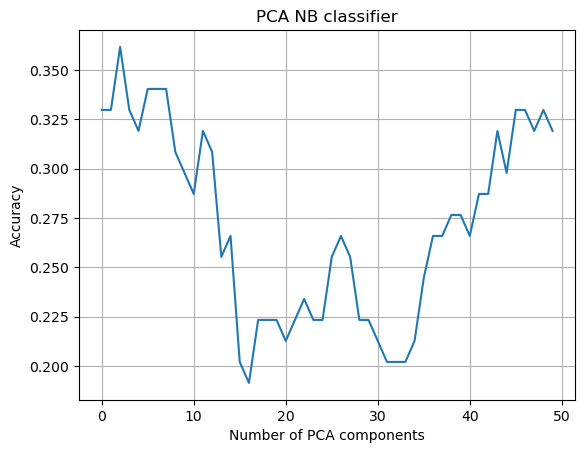

[KPCA rbf] NB classifier accuracy with 50 components: 4.26%


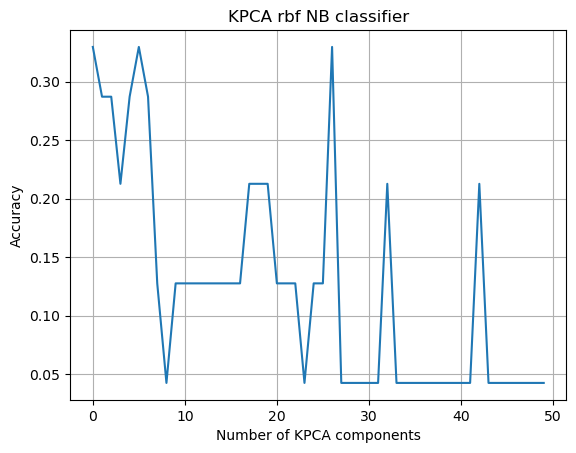

[KPCA poly] NB classifier accuracy with 50 components: 18.09%


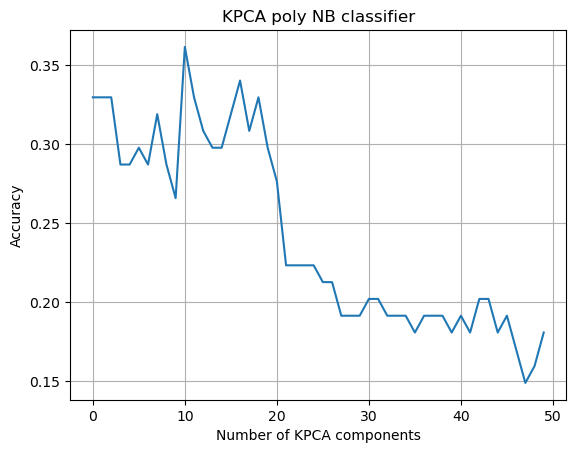

[KPCA linear] NB classifier accuracy with 50 components: 31.91%


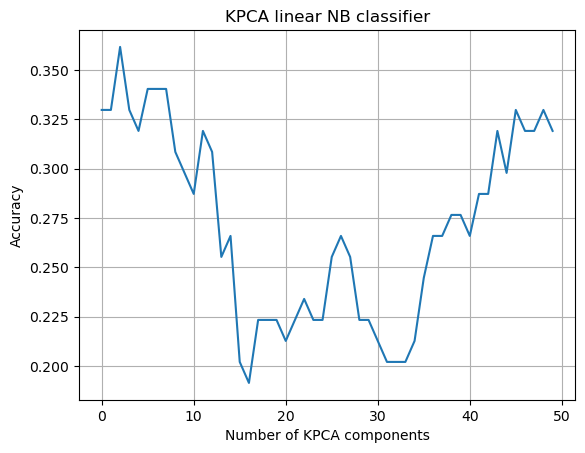

In [ ]:
#Whole data Classifiers
classifer_data = pd.read_csv('colon.csv')
classifier_data = classifer_data.iloc[:, :-1]
classifier_labels = classifer_data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(classifier_data, classifier_labels, test_size=0.2, random_state=42)
# Naive Bayes classifier applied to the whole dataset
NB = GaussianNB()
NB.fit(X_train, y_train)
NB_pred = NB.predict(X_test)
NB_accuracy = accuracy_score(y_test, NB_pred) * 100
print('[Whole data] NB classifier accuracy: %.2f%%' % NB_accuracy)
# Apply PCA and KPCA to NB classifier
NB_results = []
for i in range(1, 51):
    pca = PCA(n_components=i)
    train_reduced = pca.fit_transform(X_train)
    test_reduced = pca.transform(X_test)
    NB = GaussianNB()
    NB.fit(train_reduced, y_train)
    y_NB_pred = NB.predict(test_reduced)
    PCA_accuracy = accuracy_score(y_test, y_NB_pred)
    NB_results.append(PCA_accuracy)
    if i == 50:
        final_PCA_accuracy = PCA_accuracy

print('[PCA] NB classifier accuracy with 50 components: %.2f%%' % (final_PCA_accuracy * 100))
plt.plot(NB_results)
plt.grid()
plt.xlabel('Number of PCA components')
plt.ylabel('Accuracy')
plt.title('PCA NB classifier')
plt.show()

NB_kpca_rbf_results = []
for i in range(1, 51):
    kpca = KernelPCA(n_components=i, kernel='rbf', gamma=1.0)
    train_reduced = kpca.fit_transform(X_train)
    test_reduced = kpca.transform(X_test)
    NB = GaussianNB()
    NB.fit(train_reduced, y_train)
    y_NB_kpca_pred = NB.predict(test_reduced)
    KPCA_rbf_accuracy = accuracy_score(y_test, y_NB_kpca_pred)
    NB_kpca_rbf_results.append(KPCA_rbf_accuracy)
    if i == 50:
        final_KPCA_rbf_accuracy = KPCA_rbf_accuracy

print('[KPCA rbf] NB classifier accuracy with 50 components: %.2f%%' % (final_KPCA_rbf_accuracy * 100))
plt.plot(NB_kpca_rbf_results)
plt.grid()
plt.xlabel('Number of KPCA components')
plt.ylabel('Accuracy')
plt.title('KPCA rbf NB classifier')
plt.show()

NB_kpca_poly_results = []
for i in range(1, 51):
    kpca = KernelPCA(n_components=i, kernel='poly', degree=3)
    train_reduced = kpca.fit_transform(X_train)
    test_reduced = kpca.transform(X_test)
    NB = GaussianNB()
    NB.fit(train_reduced, y_train)
    y_NB_kpca_poly_pred = NB.predict(test_reduced)
    KPCA_poly_accuracy = accuracy_score(y_test, y_NB_kpca_poly_pred)
    NB_kpca_poly_results.append(KPCA_poly_accuracy)
    if i == 50:
        final_KPCA_poly_accuracy = KPCA_poly_accuracy

print('[KPCA poly] NB classifier accuracy with 50 components: %.2f%%' % (final_KPCA_poly_accuracy * 100))
plt.plot(NB_kpca_poly_results)
plt.grid()
plt.xlabel('Number of KPCA components')
plt.ylabel('Accuracy')
plt.title('KPCA poly NB classifier')
plt.show()

NB_kpca_linear_results = []
for i in range(1, 51):
    kpca = KernelPCA(n_components=i, kernel='linear')
    train_reduced = kpca.fit_transform(X_train)
    test_reduced = kpca.transform(X_test)
    NB = GaussianNB()
    NB.fit(train_reduced, y_train)
    y_NB_kpca_linear_pred = NB.predict(test_reduced)
    KPCA_linear_accuracy = accuracy_score(y_test, y_NB_kpca_linear_pred)
    NB_kpca_linear_results.append(KPCA_linear_accuracy)
    if i == 50:
        final_KPCA_linear_accuracy = KPCA_linear_accuracy

print('[KPCA linear] NB classifier accuracy with 50 components: %.2f%%' % (final_KPCA_linear_accuracy * 100))
plt.plot(NB_kpca_linear_results)
plt.grid()
plt.xlabel('Number of KPCA components')
plt.ylabel('Accuracy')
plt.title('KPCA linear NB classifier')
plt.show()

[Whole data] LDA classifier accuracy: 26.60%
[PCA] LDA classifier accuracy with 50 components: 31.91%


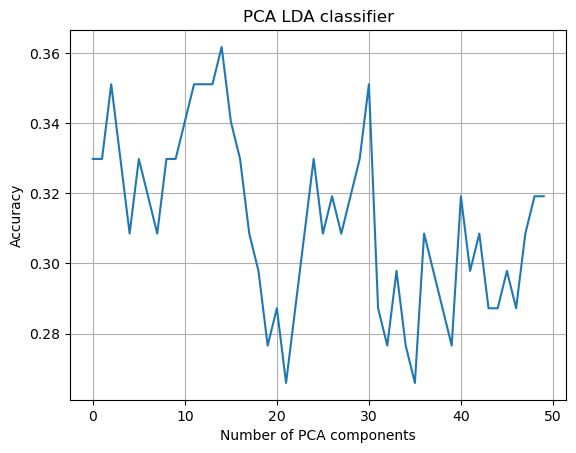

[KPCA rbf] LDA classifier accuracy with 50 components: 32.98%


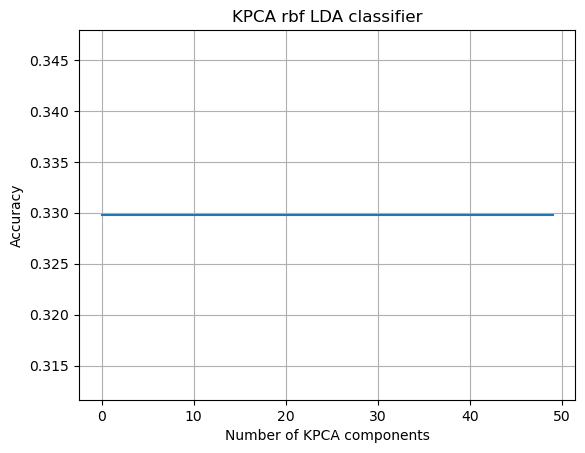

[KPCA poly] LDA classifier accuracy with 50 components: 30.85%


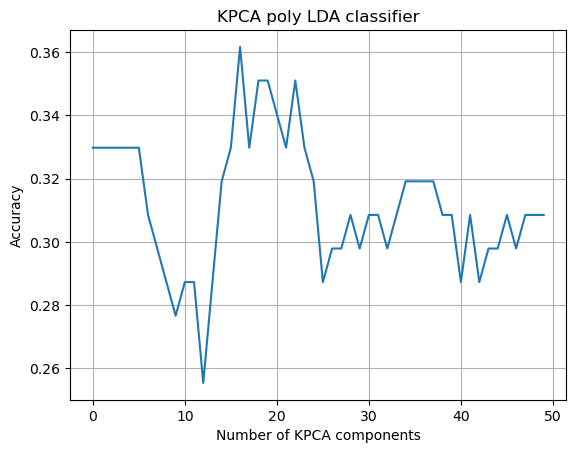

[KPCA linear] LDA classifier accuracy with 50 components: 31.91%


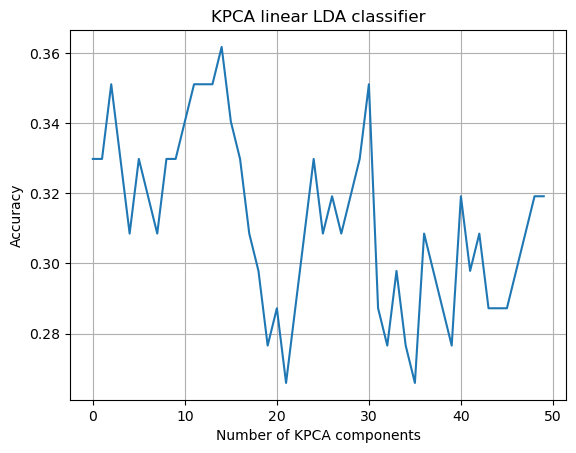

In [ ]:
#Whole data Classifiers
classifer_data = pd.read_csv('colon.csv')
classifier_data = classifer_data.iloc[:, :-1]
classifier_labels = classifer_data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(classifier_data, classifier_labels, test_size=0.2, random_state=42)
# LDA classifier applied to the whole dataset
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train, y_train)
LDA_pred = LDA.predict(X_test)
LDA_accuracy = accuracy_score(y_test, LDA_pred) * 100
print('[Whole data] LDA classifier accuracy: %.2f%%' % LDA_accuracy)
# Apply PCA and KPCA to LDA classifier
LDA_results = []
for i in range(1, 51):
    pca = PCA(n_components=i)
    train_reduced = pca.fit_transform(X_train)
    test_reduced = pca.transform(X_test)
    LDA = LinearDiscriminantAnalysis()
    LDA.fit(train_reduced, y_train)
    y_LDA_pred = LDA.predict(test_reduced)
    PCA_accuracy = accuracy_score(y_test, y_LDA_pred)
    LDA_results.append(PCA_accuracy)
    if i == 50:
        final_PCA_accuracy = PCA_accuracy

print('[PCA] LDA classifier accuracy with 50 components: %.2f%%' % (final_PCA_accuracy * 100))
plt.plot(LDA_results)
plt.grid()
plt.xlabel('Number of PCA components')
plt.ylabel('Accuracy')
plt.title('PCA LDA classifier')
plt.show()

LDA_kpca_rbf_results = []
for i in range(1, 51):
    kpca = KernelPCA(n_components=i, kernel='rbf', gamma=1.0)
    train_reduced = kpca.fit_transform(X_train)
    test_reduced = kpca.transform(X_test)
    LDA = LinearDiscriminantAnalysis()
    LDA.fit(train_reduced, y_train)
    y_LDA_kpca_pred = LDA.predict(test_reduced)
    KPCA_rbf_accuracy = accuracy_score(y_test, y_LDA_kpca_pred)
    LDA_kpca_rbf_results.append(KPCA_rbf_accuracy)
    if i == 50:
        final_KPCA_rbf_accuracy = KPCA_rbf_accuracy

print('[KPCA rbf] LDA classifier accuracy with 50 components: %.2f%%' % (final_KPCA_rbf_accuracy * 100))
plt.plot(LDA_kpca_rbf_results)
plt.grid()
plt.xlabel('Number of KPCA components')
plt.ylabel('Accuracy')
plt.title('KPCA rbf LDA classifier')
plt.show()

LDA_kpca_poly_results = []
for i in range(1, 51):
    kpca = KernelPCA(n_components=i, kernel='poly', degree=3)
    train_reduced = kpca.fit_transform(X_train)
    test_reduced = kpca.transform(X_test)
    LDA = LinearDiscriminantAnalysis()
    LDA.fit(train_reduced, y_train)
    y_LDA_kpca_poly_pred = LDA.predict(test_reduced)
    KPCA_poly_accuracy = accuracy_score(y_test, y_LDA_kpca_poly_pred)
    LDA_kpca_poly_results.append(KPCA_poly_accuracy)
    if i == 50:
        final_KPCA_poly_accuracy = KPCA_poly_accuracy

print('[KPCA poly] LDA classifier accuracy with 50 components: %.2f%%' % (final_KPCA_poly_accuracy * 100))
plt.plot(LDA_kpca_poly_results)
plt.grid()
plt.xlabel('Number of KPCA components')
plt.ylabel('Accuracy')
plt.title('KPCA poly LDA classifier')
plt.show()

LDA_kpca_linear_results = []
for i in range(1, 51):
    kpca = KernelPCA(n_components=i, kernel='linear')
    train_reduced = kpca.fit_transform(X_train)
    test_reduced = kpca.transform(X_test)
    LDA = LinearDiscriminantAnalysis()
    LDA.fit(train_reduced, y_train)
    y_LDA_kpca_linear_pred = LDA.predict(test_reduced)
    KPCA_linear_accuracy = accuracy_score(y_test, y_LDA_kpca_linear_pred)
    LDA_kpca_linear_results.append(KPCA_linear_accuracy)
    if i == 50:
        final_KPCA_linear_accuracy = KPCA_linear_accuracy

print('[KPCA linear] LDA classifier accuracy with 50 components: %.2f%%' % (final_KPCA_linear_accuracy * 100))
plt.plot(LDA_kpca_linear_results)
plt.grid()
plt.xlabel('Number of KPCA components')
plt.ylabel('Accuracy')
plt.title('KPCA linear LDA classifier')
plt.show()

[Whole data] SVM classifier accuracy: 32.98%
[PCA] SVM classifier accuracy with 50 components: 35.11%


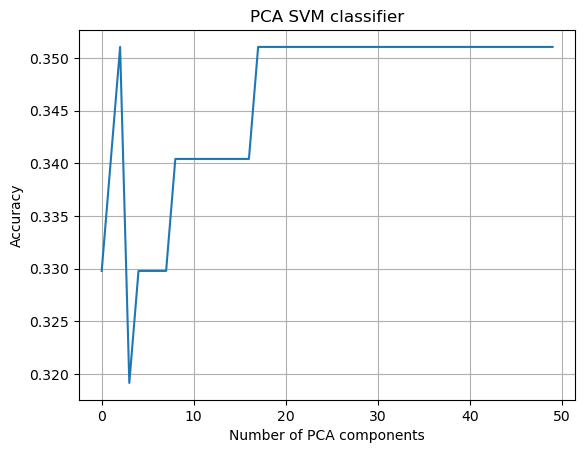

[KPCA rbf] SVM classifier accuracy with 50 components: 32.98%


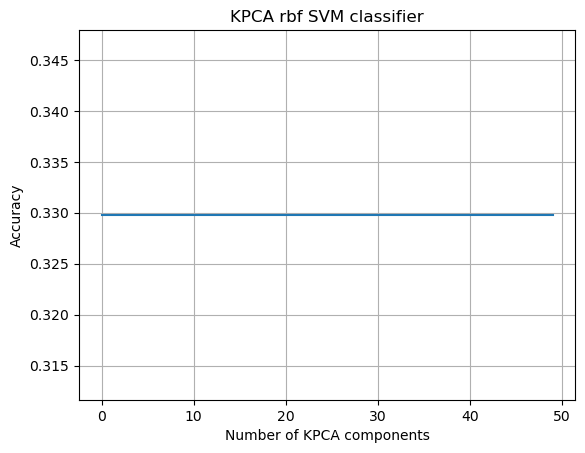

[KPCA poly] SVM classifier accuracy with 50 components: 35.11%


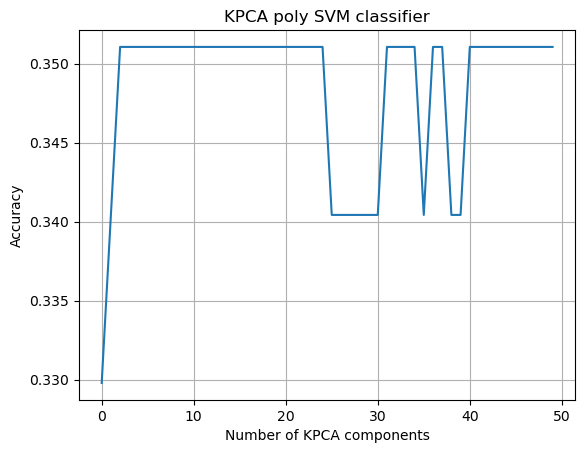

[KPCA linear] SVM classifier accuracy with 50 components: 35.11%


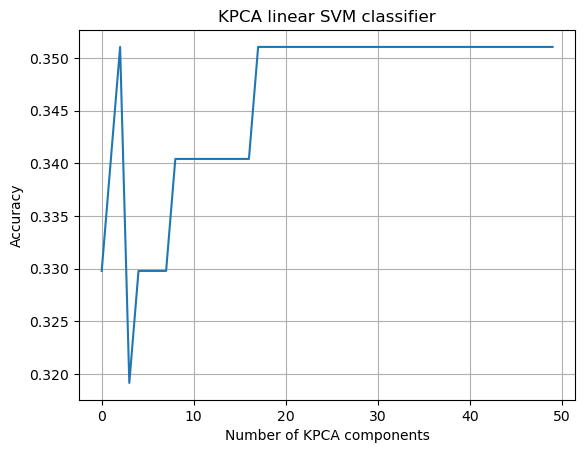

In [ ]:
#Whole data Classifiers
classifer_data = pd.read_csv('colon.csv')
classifier_data = classifer_data.iloc[:, :-1]
classifier_labels = classifer_data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(classifier_data, classifier_labels, test_size=0.2, random_state=42)
# SVM classifier applied to the whole dataset
SVM = SVC()
SVM.fit(X_train, y_train)
SVM_pred = SVM.predict(X_test)
SVM_accuracy = accuracy_score(y_test, SVM_pred) * 100
print('[Whole data] SVM classifier accuracy: %.2f%%' % SVM_accuracy)
# Apply PCA and KPCA to SVM classifier
SVM_results = []
for i in range(1, 51):
    pca = PCA(n_components=i)
    train_reduced = pca.fit_transform(X_train)
    test_reduced = pca.transform(X_test)
    SVM = SVC()
    SVM.fit(train_reduced, y_train)
    y_SVM_pred = SVM.predict(test_reduced)
    PCA_accuracy = accuracy_score(y_test, y_SVM_pred)
    SVM_results.append(PCA_accuracy)
    if i == 50:
        final_PCA_accuracy = PCA_accuracy

print('[PCA] SVM classifier accuracy with 50 components: %.2f%%' % (final_PCA_accuracy * 100))
plt.plot(SVM_results)
plt.grid()
plt.xlabel('Number of PCA components')
plt.ylabel('Accuracy')
plt.title('PCA SVM classifier')
plt.show()

SVM_kpca_rbf_results = []
for i in range(1, 51):
    kpca = KernelPCA(n_components=i, kernel='rbf', gamma=1.0)
    train_reduced = kpca.fit_transform(X_train)
    test_reduced = kpca.transform(X_test)
    SVM = SVC()
    SVM.fit(train_reduced, y_train)
    y_SVM_kpca_pred = SVM.predict(test_reduced)
    KPCA_rbf_accuracy = accuracy_score(y_test, y_SVM_kpca_pred)
    SVM_kpca_rbf_results.append(KPCA_rbf_accuracy)
    if i == 50:
        final_KPCA_rbf_accuracy = KPCA_rbf_accuracy

print('[KPCA rbf] SVM classifier accuracy with 50 components: %.2f%%' % (final_KPCA_rbf_accuracy * 100))
plt.plot(SVM_kpca_rbf_results)
plt.grid()
plt.xlabel('Number of KPCA components')
plt.ylabel('Accuracy')
plt.title('KPCA rbf SVM classifier')
plt.show()

SVM_kpca_poly_results = []
for i in range(1, 51):
    kpca = KernelPCA(n_components=i, kernel='poly', degree=3)
    train_reduced = kpca.fit_transform(X_train)
    test_reduced = kpca.transform(X_test)
    SVM = SVC()
    SVM.fit(train_reduced, y_train)
    y_SVM_kpca_poly_pred = SVM.predict(test_reduced)
    KPCA_poly_accuracy = accuracy_score(y_test, y_SVM_kpca_poly_pred)
    SVM_kpca_poly_results.append(KPCA_poly_accuracy)
    if i == 50:
        final_KPCA_poly_accuracy = KPCA_poly_accuracy

print('[KPCA poly] SVM classifier accuracy with 50 components: %.2f%%' % (final_KPCA_poly_accuracy * 100))
plt.plot(SVM_kpca_poly_results)
plt.grid()
plt.xlabel('Number of KPCA components')
plt.ylabel('Accuracy')
plt.title('KPCA poly SVM classifier')
plt.show()

SVM_kpca_linear_results = []
for i in range(1, 51):
    kpca = KernelPCA(n_components=i, kernel='linear')
    train_reduced = kpca.fit_transform(X_train)
    test_reduced = kpca.transform(X_test)
    SVM = SVC()
    SVM.fit(train_reduced, y_train)
    y_SVM_kpca_linear_pred = SVM.predict(test_reduced)
    KPCA_linear_accuracy = accuracy_score(y_test, y_SVM_kpca_linear_pred)
    SVM_kpca_linear_results.append(KPCA_linear_accuracy)
    if i == 50:
        final_KPCA_linear_accuracy = KPCA_linear_accuracy

print('[KPCA linear] SVM classifier accuracy with 50 components: %.2f%%' % (final_KPCA_linear_accuracy * 100))
plt.plot(SVM_kpca_linear_results)
plt.grid()
plt.xlabel('Number of KPCA components')
plt.ylabel('Accuracy')
plt.title('KPCA linear SVM classifier')
plt.show()

[Whole data] Bayes classifier accuracy: 4.26%
Bayes classifier accuracy with 30 components: 4.26%


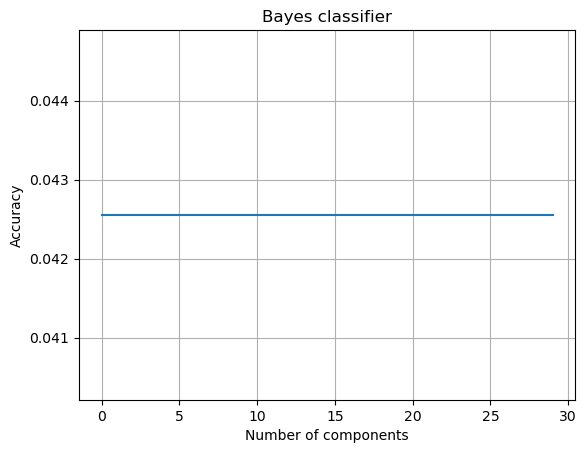

In [7]:
#Whole data Classifiers
classifer_data = pd.read_csv('colon.csv')
classifier_data = classifer_data.iloc[:, :-1]
classifier_labels = classifer_data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(classifier_data, classifier_labels, test_size=0.2, random_state=42)
# Bayes classifier applied to the whole dataset
prior_probabilities, class_means, cov_matrices = Bayes.bayes_classifier(X_train, y_train)
Bayes_pred = Bayes.predict(X_test, prior_probabilities, class_means, cov_matrices)
Bayes_accuracy = accuracy_score(y_test, Bayes_pred) * 100
print('[Whole data] Bayes classifier accuracy: %.2f%%' % Bayes_accuracy)
# Apply Bayes classifier
Bayes_results = []
for i in range(1, 31):
    prior_probabilities, class_means, cov_matrices = Bayes.bayes_classifier(X_train, y_train)
    Bayes_pred = Bayes.predict(X_test, prior_probabilities, class_means, cov_matrices)
    Bayes_accuracy = accuracy_score(y_test, Bayes_pred)
    Bayes_results.append(Bayes_accuracy)
    if i == 30:
        final_Bayes_accuracy = Bayes_accuracy

print('Bayes classifier accuracy with 30 components: %.2f%%' % (final_Bayes_accuracy * 100))
plt.plot(Bayes_results)
plt.grid()
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.title('Bayes classifier')
plt.show()

# 4. Clustering Experiment: In this section, you will perform clustering on the dataset points and features.

In [5]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Cluster the data points into 5 clusters using the following methods: 
    Kmeans
    Expectation Maximization

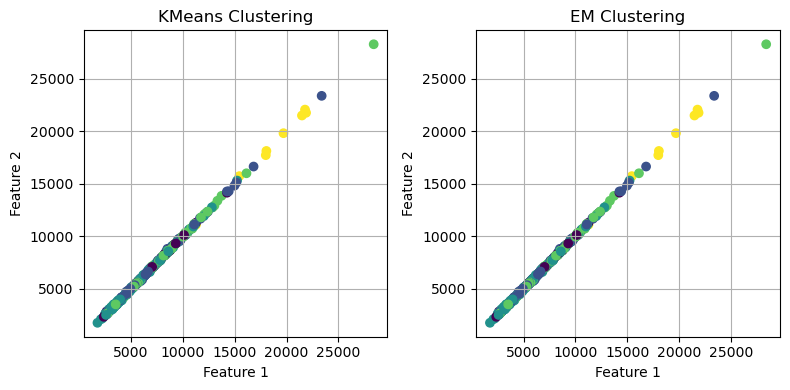

In [ ]:
# Run First cell to get the data
# Have to readcsv
data = pd.read_csv('colon.csv')
data = data.iloc[:, :-1].to_numpy()
#print(data.shape)
# Apply Kmeans with 5 clusters
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
kmeans_label = kmeans.fit_predict(data)
# Visualize the results using the map
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], c=kmeans_label)
plt.title('KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid()
# Apply EM clustering with 5 clusters
gmm = GaussianMixture(n_components=5, random_state=42)
gmm_label = gmm.fit_predict(data)
# Visualize EM clustering
plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], c=gmm_label)
plt.title('EM Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid()
plt.tight_layout()
plt.show()

### Kernel Kmeans " Use RBF kernel, Polynomial Kernel, and linear Kernel"

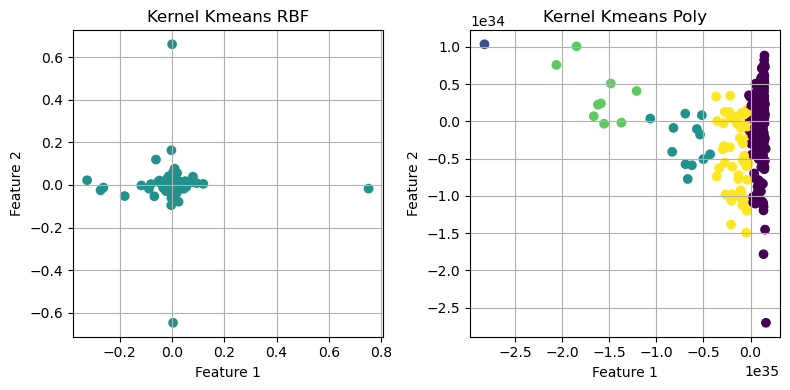

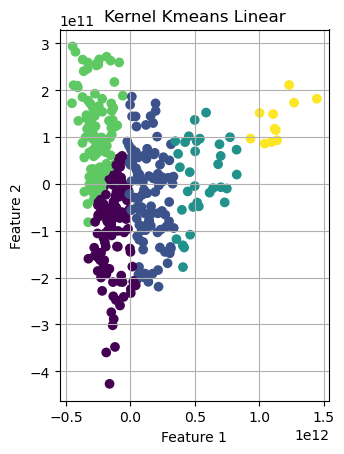

In [ ]:
# get RBF train data
#print(projected_train_kpca_rbf.shape)
# Apply Kernel K means on the RBF kernel
kmeans_rbf = KMeans(n_clusters=5, n_init=10, random_state=42)
kmeans_rbf_label = kmeans_rbf.fit_predict(projected_train_kpca_rbf)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(projected_train_kpca_rbf[:, 0], projected_train_kpca_rbf[:, 1], c=kmeans_rbf_label)
plt.title('Kernel Kmeans RBF')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid()
# get Poly train data
#print(projected_train_kpca_poly.shape)
kmeans_poly = KMeans(n_clusters=5, n_init=10, random_state=42)
kmeans_poly_label = kmeans_poly.fit_predict(projected_train_kpca_poly)
plt.subplot(1, 2, 2)
plt.scatter(projected_train_kpca_poly[:, 0], projected_train_kpca_poly[:, 1], c=kmeans_poly_label)
plt.title('Kernel Kmeans Poly')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid()
plt.tight_layout()
plt.show()
# get Linear train data
#print(projected_train_kpca_linear.shape)
kmeans_linear = KMeans(n_clusters=5, n_init=10, random_state=42)
kmeans_linear_label = kmeans_linear.fit_predict(projected_train_kpca_linear)
plt.subplot(1, 2, 1)
plt.scatter(projected_train_kpca_linear[:, 0], projected_train_kpca_linear[:, 1], c=kmeans_linear_label)
plt.title('Kernel Kmeans Linear')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid()
plt.tight_layout()
plt.show()

## Cluster the features into 2 groups using the following methods: 
    Kmeans
    Expectation Maximization
    Kernel Kmeans " Use RBF kernel, Polynomial Kernel, and linear Kernel"
    
## 6. Test these two clusters on the 5 stage classification" SVM, KNN, NB", use the group with less number of feartures.

In [30]:
# Load the dataset
classifer_data = pd.read_csv('colon.csv')
classifier_data = classifer_data.iloc[:, :-1]
classifier_labels = classifer_data.iloc[:, -1]
X = classifier_data
y = classifier_labels
# Project the data using kernelPCA with RBF, Poly, and Linear
kpca_rbf = KernelPCA(n_components=2, kernel='rbf', gamma=1.0, random_state=42)
projected_rbf = kpca_rbf.fit_transform(X)

kpca_poly = KernelPCA(n_components=2, kernel='poly', degree=3, random_state=42)
projected_poly = kpca_poly.fit_transform(X)

kpca_linear = KernelPCA(n_components=2, kernel='linear', random_state=42)
projected_linear = kpca_linear.fit_transform(X)
# Apply Kmeans on projected data
kmeans_rbf = KMeans(n_clusters=2, n_init=10, random_state=42)
rbf_labels = kmeans_rbf.fit_predict(projected_rbf)

kmeans_poly = KMeans(n_clusters=2, n_init=10, random_state=42)
poly_labels = kmeans_poly.fit_predict(projected_poly)

kmeans_linear = KMeans(n_clusters=2, n_init=10, random_state=42)
linear_labels = kmeans_linear.fit_predict(projected_linear)
# Apply EM Expectation maximization on projected data
gmm_rbf = GaussianMixture(n_components=2, random_state=42)
gmm_labels_rbf = gmm_rbf.fit_predict(projected_rbf)

gmm_poly = GaussianMixture(n_components=2, random_state=42)
gmm_labels_poly = gmm_poly.fit_predict(projected_poly)

gmm_linear = GaussianMixture(n_components=2, random_state=42)
gmm_labels_linear = gmm_linear.fit_predict(projected_linear)
# Test the two clusters on 5 stage classification
def test_classifiers(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # SVM
    SVM = SVC()
    SVM.fit(X_train, y_train)
    y_SVM_pred = SVM.predict(X_test)
    SVM_acc = accuracy_score(y_test, y_SVM_pred)

    #KNN
    KNN = KNeighborsClassifier()
    KNN.fit(X_train, y_train)
    y_KNN_pred = KNN.predict(X_test)
    KNN_acc = accuracy_score(y_test, y_KNN_pred)

    #Naive Bayes
    NB = GaussianNB()
    NB.fit(X_train, y_train)
    y_NB_pred = NB.predict(X_test)
    NB_acc = accuracy_score(y_test, y_NB_pred)

    #Bayes
    prior_probabilities, class_means, cov_matrices = Bayes.bayes_classifier(X_train, y_train)
    y_Bayes_pred = Bayes.predict(X_test, prior_probabilities, class_means, cov_matrices)
    Bayes_acc = accuracy_score(y_test, y_Bayes_pred)

    #LDA
    LDA = LinearDiscriminantAnalysis()
    LDA.fit(X_train, y_train)
    y_LDA_pred = LDA.predict(X_test)
    LDA_acc = accuracy_score(y_test, y_LDA_pred)

    return SVM_acc, KNN_acc, NB_acc, LDA_acc, Bayes_acc

SVM_acc, KNN_acc, NB_acc, LDA_acc, Bayes_acc = test_classifiers(X, poly_labels)
#print the accuracy scores for the 5 stage classifiers
print('SVM classifier accuracy: %.2f%%' % (SVM_acc * 100))
print('KNN classifier accuracy: %.2f%%' % (KNN_acc * 100))
print('Naive Bayes classifier accuracy: %.2f%%' % (NB_acc * 100))
print('LDA classifier accuracy: %.2f%%' % (LDA_acc * 100))
print('Bayes classifier accuracy: %.2f%%' % (Bayes_acc * 100))

SVM classifier accuracy: 100.00%
KNN classifier accuracy: 100.00%
Naive Bayes classifier accuracy: 90.43%
LDA classifier accuracy: 91.49%
Bayes classifier accuracy: 4.26%
